<a href="https://colab.research.google.com/github/dahouda2pro/Sentiment-Analysis/blob/main/spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Dependencies

In [ ]:
!pip install tensorflow-text

     |████████████████████████████████| 4.4 MB 5.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import time

# 2. Loading Data

In [ ]:
%%time
# load data
df = pd.read_csv('spam_data.csv')

CPU times: user 13.5 ms, sys: 6.93 ms, total: 20.4 ms
Wall time: 24.1 ms


In [ ]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# 3. Spam Detection Exploratory Data Analysis

In [ ]:
# check count and unique and top values and their frequency
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:

#1) We first calculated the percentage of data that needs to be balanced by dividing minority (spam) by majority(ham) :
# check percentage of data - states how much data needs to be balanced
print(str(round(747/4825,2))+'%')

0.15%


In [ ]:
# 2) We then create 2 new datasets namely ham and spam and filtered the data having categories as spam and ham and append it to the respective dataset and finally printed their shape to confirm the filtering and creation:)
# creating 2 new dataframe as df_ham , df_spam

df_spam = df[df['Category']=='spam']

df_ham = df[df['Category']=='ham']

print("Ham Dataset Shape:", df_ham.shape)

print("Spam Dataset Shape:", df_spam.shape)

Ham Dataset Shape: (4825, 2)
Spam Dataset Shape: (747, 2)


In [ ]:
# 3) Now we will sample the ham dataset using the sample() method with the shape of our spam dataset and to be more specific load it into a new dataframe df_ham_downsampled and print its shape to cross verify.
# downsampling ham dataset - take only random 747 example
# will use df_spam.shape[0] - 747
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
# 4) Finally we will concatenate our df_ham_downsampled and df_spam to create a final dataframe called df_balalnced.
# concating both dataset - df_spam and df_ham_balanced to create df_balanced dataset
df_balanced = pd.concat([df_spam , df_ham_downsampled])

In [ ]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [ ]:
df_balanced.sample(10)

,Category,Message
5177,ham,Very strange. and are watching the 2nd one n...
5077,ham,"Well, i'm glad you didn't find it totally disa..."
2388,ham,Also where's the piece
5342,spam,u r subscribed 2 TEXTCOMP 250 wkly comp. 1st w...
3906,spam,Do you want a new video handset? 750 anytime a...
3534,ham,"Sorry, I'll call later"
3033,ham,Jokin only lar... :-) depends on which phone m...
2941,spam,You have 1 new message. Please call 08712400200.
5414,ham,East coast
4948,spam,Great News! Call FREEFONE 08006344447 to claim...


# 4. Preprocessing of Spam Detection Data

As can be seen, we have only text as categorical data, and the model doesn’t understand them. So instead of text, we can just assign integer labels to our class ham and spam as 0 and 1 respectively, and store it in new column spam. This is called- Hot-Encoding

In [ ]:
# creating numerical repersentation of category - one hot encoding
df_balanced['spam'] = df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)

In [ ]:
# displaying data - spam -1 , ham-0
df_balanced.sample(4)

,Category,Message,spam
3144,ham,Boy; I love u Grl: Hogolo Boy: gold chain kods...,0
2242,ham,U buy newspapers already?,0
4286,ham,I pocked you up there before,0
4823,spam,u r a winner U ave been specially selected 2 r...,1


# 5. Train Test Split Strategy

It states out of all data (population) a large amount of data goes in for training(about80%) which has inputs(Messages) and Labels(1/,0) and the remaining 20% will not be fed to the model. When we further do evaluation we can just predict on that 20% and see how it performs as the model will not be biased now.

* Note :- it is generally considered to split data as 80:20 as good ratio but can be experimented:)

Here:

X_train, y_train – training inputs and labels – Training Set
X_test, y_test – testing inputs and labels – Testing Set

In [ ]:
# loading train test split

from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'],
                                                    stratify = df_balanced['spam'])

# 6. Model Creation

To create our model we will first download the bert preprocessor and encoder(for more info refer to the previous article ) as it allows us to use them as function pointers where one can feed our inputs and get the processed output and embedding. Also, this helps in better readability of the code

In [ ]:
# downloading preprocessing files and model
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [ ]:
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
preprocessed_text = bert_preprocessor(text_input)
embeed = bert_encoder(preprocessed_text)
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embeed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

In [ ]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential
from sklearn import metrics

def recall_m(y_true, y_pred):
    true_positives  = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possibles_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    recall = true_positives / (possibles_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives  = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def roc_auc(predictions, target):
    tg, pr, thsld = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(tg, pr)
    return roc_auc

In [ ]:
# creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

In [ ]:
# check the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           Inputs[0][0]                     
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 7 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [ ]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

In [ ]:
# compiling our model
# Compile The Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m])
#model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = Metrics)

In [ ]:
%%time
#history = model.fit(X_train, y_train, epochs = 10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
35/35 [==============================] - 708s 20s/step - loss: 0.6672 - accuracy: 0.6116 - precision_m: 0.5958 - recall_m: 0.9143 - val_loss: 0.5631 - val_accuracy: 0.8663 - val_precision_m: 0.8669 - val_recall_m: 1.0000
Epoch 2/5
35/35 [==============================] - 697s 20s/step - loss: 0.5338 - accuracy: 0.7902 - precision_m: 0.7746 - recall_m: 1.0000 - val_loss: 0.4743 - val_accuracy: 0.8824 - val_precision_m: 0.9387 - val_recall_m: 1.0000
Epoch 3/5
35/35 [==============================] - 697s 20s/step - loss: 0.4632 - accuracy: 0.8482 - precision_m: 0.8517 - recall_m: 1.0000 - val_loss: 0.4198 - val_accuracy: 0.8610 - val_precision_m: 0.8029 - val_recall_m: 1.0000
Epoch 4/5
35/35 [==============================] - 699s 20s/step - loss: 0.4169 - accuracy: 0.8625 - precision_m: 0.8493 - recall_m: 1.0000 - val_loss: 0.3730 - val_accuracy: 0.8957 - val_precision_m: 0.8549 - val_recall_m: 1.0000
Epoch 5/5
35/35 [==============================] - 703s 20s/step - loss: 0.3

7. Model Evaluation

In [ ]:
# Evaluating performance
model.evaluate(X_test,y_test)

12/12 [==============================] - 177s 15s/step - loss: 0.3451 - accuracy: 0.9011 - precision_m: 0.8975 - recall_m: 1.0000


[0.34509047865867615, 0.9010695219039917, 0.8975103497505188, 1.0]

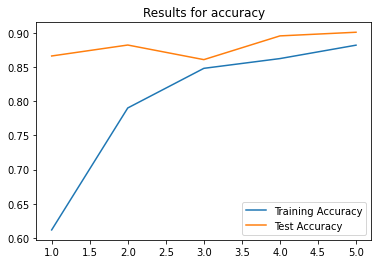

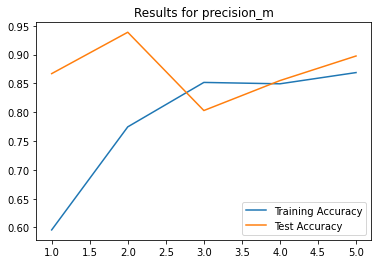

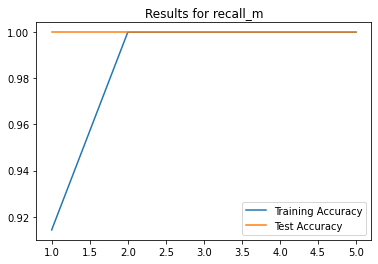

In [ ]:
# Plot the evaluation metrics by epoch for the model to see if we are over or underfitting

for i in ['accuracy', 'precision_m', 'recall_m']:
    accuracy = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(accuracy) + 1)
    
    plt.figure()
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Test Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()